In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2024-08-06 07:49:37--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  32.8MB/s    in 2.4s    

2024-08-06 07:49:40 (32.8 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



# 라이브러리

In [ ]:
# 파이썬 표준 라이브러리
import gc
import random
import string
import re

# 파이썬 서드파티 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sentencepiece as spm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import ops

# 클래스

## 위치 임베딩

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length: int, input_dim: int, output_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens *= tf.math.sqrt(tf.cast(self.output_dim, tf.float32))
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
        })
        return config

## 디코더 레이어

In [ ]:
class DecoderLayer(layers.Layer):
    def __init__(self, embed_dim: int, dense_dim: int, num_heads: int, dropout_rate: float=0.2, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.dense_proj = keras.Sequential([
            layers.Dense(units=dense_dim, activation="relu"),
            layers.Dense(units=embed_dim),
            layers.Dropout(rate=dropout_rate)
        ])
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-7) # 16비트 연산을 지원하지 않는 GPU의 경우 오류가 나므로 32비트 연산으로 바꾸기 위해 설정
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-7)

    def call(self, inputs, decoder_pad_mask, causal_mask):
        attention_output_1 = self.attention_1(
            inputs,
            inputs,
            attention_mask=decoder_pad_mask & causal_mask)
        attention_output_1 = self.layernorm_1(layers.Add()([inputs, attention_output_1])) # inputs + attention_output_1는 mask 전파가 안됨
        proj_output = self.dense_proj(attention_output_1)
        return self.layernorm_2(layers.Add()([attention_output_1, proj_output])) # attention_output_2 + proj_output는 mask 전파가 안됨

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
            "dropout_rate": self.dropout_rate
        })
        return config

## GPT

In [ ]:
class GPT(keras.Model):
    @staticmethod
    def pad_mask(input_ids):
        return tf.math.not_equal(input_ids, 0)[:, tf.newaxis]

    @staticmethod
    def causal_mask(decoder_sequence_length):
        return tf.linalg.band_part(tf.ones((decoder_sequence_length, decoder_sequence_length), tf.bool), -1, 0)

    def __init__(self, *, num_layers, sequence_length, input_dim, embed_dim,
                 dense_dim, num_heads, dropout_rate):
        super().__init__()
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.pos_embedding = PositionalEmbedding(sequence_length=sequence_length,
                                                 input_dim=input_dim,
                                                output_dim=embed_dim,
                                                 name="Decoder_PositionalEmbedding")
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

        self.dec_layers = [
                            DecoderLayer(embed_dim=embed_dim, dense_dim=dense_dim,
                                         num_heads=num_heads, dropout_rate=dropout_rate)
                            for _ in range(num_layers)]

        self.final_layer = tf.keras.layers.Dense(units=input_dim)

    def call(self, inputs):
        decoder_pad_mask = GPT.pad_mask(input_ids=inputs)
        causal_mask = GPT.causal_mask(decoder_sequence_length=tf.shape(inputs)[1])

        # inputs -> Token-IDs Shape: (batch, decoder_sequence_length)
        inputs = self.pos_embedding(inputs)  # Shape: (batch_size, decoder_sequence_length, embed_dim)
        inputs = self.dropout(inputs)

        for i in range(self.num_layers):
            inputs  = self.dec_layers[i](inputs=inputs, decoder_pad_mask=decoder_pad_mask, causal_mask=causal_mask)

        logits = self.final_layer(inputs)  # Shape: (batch_size, decoder_sequence_length, target_vocab_size)

        try:
            # losses/metrics가 커지지 않게 keras_mask를 제거
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

## 1사이클 스케줄링

In [ ]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embed_dim, warmup_steps=4000):
        super().__init__()
        self.embed_dim = embed_dim
        self.embed_dim = tf.cast(self.embed_dim, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.embed_dim) * tf.math.minimum(arg1, arg2)

## 텍스트 생성기

In [ ]:
class TextGenerator(tf.Module):
    # 날짜 문자열 전처리 함수
    @staticmethod
    def preprocess_date(text_: re.Match) -> str:
        """날짜 문자열을 전처리 하는 함수

        Args:
            날짜 패턴 매칭은 기본적으로 mm구분자dd구분자yyyy라고 예상
            날짜 구분자는 / . - 3개
            text_: 문자열에서 패턴 매칭

        Returns
            text_: yyyy-mm-dd 형태의 날짜 문자열
        """

        text_ = text_.group()
        m, d, y = re.split(pattern=r"/|\.|-", string=text_)
        m = m.rjust(2, "0")
        d = d.rjust(2, "0")
        return f"{y}-{m}-{d}"

    # 영어 데이터 전처리 함수
    @staticmethod
    def preprocess_text(text_: str, repeat: int=2, repl_date_format: bool=False) -> str:
        """텍스트 문자열 중 일부 규칙적인 부분을 전처리 하는 함수

        Args:
            text_: 텍스트 문자열 -> str
            repeat: 연속해서 똑같이 반복되는 문자열을 감소시킬 크기 -> int
            repl_date_format: 서양식 날짜 형태를 yyyy-mm-dd 형태로 바꿀건지 여부 -> bool

        Returns:
            text_: 전처리 된 텍스트 문자열 -> str
        """

        text_ = text_.lower()
        text_ = re.sub(pattern=rf"[^\w\s{string.punctuation}]", repl=r"", string=text_)
        text_ = re.sub(pattern=r"\?+", repl=r"?", string=text_) # ?가 2번 이상 연속되면 ?로 수정
        text_ = re.sub(pattern=r"\!+", repl=r"!", string=text_) # !가 2번 이상 연속되면 !로 수정
        text_ = re.sub(pattern=r"(?P<char>\D)(?P=char){2,}", repl=r"\g<char>" * repeat, string=text_) # 숫자가 아닌 똑같은 문자열이 3번 이상 연속되면 repeat만큼으로 수정
        text_ = re.sub(pattern=r"\.{2,}", repl=r"...", string=text_) # ..을 ...으로 변경
        text_ = re.sub(pattern=r"\.\.\.(?P<s>\w)", repl=r"... \g<s>", string=text_) # 띄어쓰기 교정
        text_ = re.sub(pattern=r"<br />", repl=" ", string=text_)
        text_ = re.sub(pattern=r"\s+", repl=" ", string=text_)

        # 만약 mm구분자dd구분자yyyy형태라면 yyyy-mm-dd로 바꿀 수 있으나 날짜 포맷 종류가 너무 많아서 False로 설정
        if repl_date_format:
            text_ = re.sub(pattern=r"[0-9]{1,2}(?P<sep>/|\.|-)[0-9]{1,2}(?P=sep)[0-9]{4}", repl=TextGenerator.preprocess_date, string=text_) # 서양식 날짜 형태를 yyyy-mm-dd로 변경

        # 영어 축약형을 풀기
        # 's 축약은 is / has 또는 아예 소유격으로 가능해서 제외
        # 'd 축약은 had / would / could 등으로 가능해서 제외
        # 'll 축약은 shall / will로 가능해서 제외
        text_ = re.sub(pattern=r"\bi'm\b", repl=r"i am", string=text_)
        text_ = re.sub(pattern=r"\b(?P<subj>you|we|they|there|who|when|where|what|how|why)'re\b", repl=r"\g<subj> are", string=text_)
        text_ = re.sub(pattern=r"\b(?P<verb>is|are|was|were|do|does|did|have|has|had|must|should|may|might|could|would|ought|dare|need)n't\b", repl=r"\g<verb> not", string=text_)
        text_ = re.sub(pattern=r"\bwon't\b", repl=r"will not", string=text_)
        text_ = re.sub(pattern=r"\bcan't\b", repl=r"can not", string=text_)
        text_ = re.sub(pattern=r"\bshan't\b", repl=r"shall not", string=text_)
        text_ = re.sub(pattern=r"\b(?P<subj>i|you|they|we|should|could|would|must|not)'ve\b", repl=r"\g<subj> have", string=text_)

        text_ = text_.strip()
        return text_

    @staticmethod
    def sample_next(logits: tf.Tensor, k: int) -> tf.Tensor:
        """top-k를 통해 다음 텍스트 선택하는 함수

        Args:
            probas: 다음 텍스트 확률들 -> tf.Tensor

        Returns:
            다음 텍스트 인덱스
        """

        logits, indices = ops.top_k(logits, k=k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(ops.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return tf.constant(np.random.choice(indices, p=preds), dtype=tf.int32)

    def __init__(self, tokenizer, target_length, model):
        self.tokenizer = tokenizer
        self.target_length = target_length
        self.model = model

    def __call__(self, sentence, k):
        sentence = TextGenerator.preprocess_text(sentence)
        start_token = self.tokenizer.encode(sentence, out_type=int)

        ends = tf.constant(0, dtype=tf.int32)
        encode_token = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
        for i in tf.range(len(start_token)):
            encode_token = encode_token.write(i, tf.constant(start_token[i], dtype=tf.int32)[tf.newaxis])

        for i in tf.range(self.target_length):
            inputs = tf.transpose(encode_token.stack())
            predictions = self.model.predict(inputs, verbose=0)
            predictions = predictions[0, -1, :] # 마지막 토큰으로부터 예측
            predicted_id = TextGenerator.sample_next(logits=predictions, k=k)

            if predicted_id == ends:
                break

            encode_token = encode_token.write(len(start_token) + i, predicted_id[tf.newaxis])

        encode_token = tf.transpose(encode_token.stack())[0]
        encode_token = encode_token.numpy().tolist()

        return self.tokenizer.DecodeIds(encode_token)

# 함수

In [ ]:
# 데이터셋 포맷 함수
def format_dataset(data) -> tuple[tuple[tf.Tensor, tf.Tensor], tf.Tensor]:
    """데이터셋 포맷을 fit 형태로 바꾸는 함수

    Args:
        data: 숫자로 인코딩된 2차원 배열

    Returns:
        (tf.Tensor, tf.Tensor)
    """
    x, y = data[:, :-1], data[:, 1:]
    return x, y

# 리스트로 tf.data.Dataset 생성 함수
def tf_dataset(data, batch_size: int) -> tf.data.Dataset:
    """RaggedTensor를 tf.data.Dataset으로 만드는 함수

    Args:
        data: 숫자로 인코딩된 2차원 배열
        batch_size: 배치 크기 -> int

    Returns:
        tf.data.Dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(len(data))
    dataset= dataset.batch(batch_size).map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE).cache()
    return dataset

# train/validation 생성 함수
def make_dataset(data, rate: float=0.9, batch_size: int=32) -> tuple[tf.data.Dataset, tf.data.Dataset]:
    """훈련/검증 데이터를 생성하는 함수

    Args:
        data: 숫자로 인코딩된 2차원 배열
        rate: 전체 데이터 중 학습 데이터의 비율 -> float(0 <= rate <= 1)
        batch_size: 배치 크기 -> int

    Returns:
        (train 데이터셋, valid 데이터셋)
        (tf.data.Dataset tf.data.Dataset)
    """
    assert sequence_length > 0
    assert 0 <= rate <= 1
    assert batch_size > 0

    np.random.shuffle(data)

    # train과 valid로 분할
    n = int(len(data) * rate)
    train_data, valid_data = data[:n], data[n:]

    # 데이터셋 생성
    train_dataset = tf_dataset(data=train_data, batch_size=batch_size)
    valid_dataset = tf_dataset(data=valid_data, batch_size=batch_size)
    return train_dataset, valid_dataset

In [ ]:
# 마스킹된 손실함수
def masked_loss(label: tf.Tensor, pred: tf.Tensor) -> tf.Tensor:
    """마스킹을 포함한 예측값과 실제값의 손실값을 계산하는 함수

    Args:
        label: 실제값 -> tf.Tensor
        pred: 예측값 -> tf.Tensor

    Returns:
        손실값 -> tf.Tensor
    """
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(y_true=label, y_pred=pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(input_tensor=loss) / tf.reduce_sum(input_tensor=mask)
    return loss

# 마스킹된 정확도 함수
def masked_accuracy(label: tf.Tensor, pred: tf.Tensor) -> tf.Tensor:
    """마스킹을 포함한 예측값과 실제값의 정확도를 계산하는 함수

    Args:
        label: 실제값 -> tf.Tensor
        pred: 예측값 -> tf.Tensor

    Returns:
        정확도 -> tf.Tensor
    """
    pred = tf.argmax(input=pred, axis=2)
    label = tf.cast(label, dtype=pred.dtype)
    matched = label == pred

    mask = label != 0

    matched = matched & mask

    matched = tf.cast(matched, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(input_tensor=matched) / tf.reduce_sum(input_tensor=mask)

# 변수

In [ ]:
SEED = 1234
tf.random.set_seed(SEED)

# 데이터 불러오기

In [ ]:
dataset = keras.utils.text_dataset_from_directory(directory="aclImdb", label_mode=None, batch_size=None)

Found 100006 files.


In [ ]:
dataset = list(dataset.as_numpy_iterator())

In [ ]:
dataset = list(map(lambda x: x.decode('utf-8'), dataset))

In [ ]:
dataset = list(map(lambda x: TextGenerator.preprocess_text(text_=x), dataset))

# Sentencepiece 토크나이저

In [ ]:
text_series = pd.Series(dataset, dtype="string")

In [ ]:
text_path = "/content/drive/MyDrive/Practice/Natural_Language/imdb_text.txt"
text_series.to_csv(text_path, sep="\t", header=False, index=False)

In [ ]:
vocab_size = 20000

corpus_path = text_path
prefix = f"tf-sp-bpe-imdb-nlp"
spm.SentencePieceTrainer.train(
    f"--input={corpus_path} --model_prefix={prefix} --vocab_size={vocab_size}" +
    " --model_type=bpe" +
    " --max_sentence_length=9999" + # 문장 최대 길이 -> 이게 너무 길면 에러발생
    " --pad_id=0 --pad_piece=<PAD>" + # pad (0)
    " --unk_id=1 --unk_piece=<UNK>" + # unknown (1)
    " --bos_id=2 --bos_piece=<s>" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=</s>" + # end of sequence (3)
    " --byte_fallback=true" + # add byte_fallback for unk tokens
    " --add_dummy_prefix=false" + # dummy_prefix(_) out
    " --user_defined_symbols=<s>,</s>,<sep>,<cls>,<mask>") # 사용자 정의 토큰

sp = spm.SentencePieceProcessor()
spm_path = f"/content/{prefix}.model"
sp.load(spm_path)

True

In [ ]:
dataset = list(map(lambda x: sp.encode(x, out_type=int), dataset))

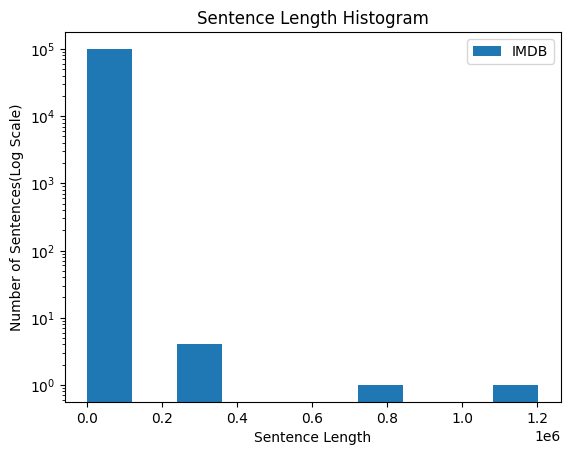

In [ ]:
# 인코딩된 길이 시각화
plt.hist(x=list(map(len, dataset)), label="IMDB")
plt.title("Sentence Length Histogram")
plt.xlabel("Sentence Length")
plt.ylabel("Number of Sentences(Log Scale)")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
sequence_length = 300
over_cnt = len([i for i in dataset if len(i) > sequence_length])
print(f"길이가 {sequence_length}보다 더 긴 리뷰의 갯수: {over_cnt}")

길이가 300보다 더 긴 리뷰의 갯수: 32882


In [ ]:
max_len = max(map(len, dataset))
print(f"가장 긴 인코딩 길이: {max_len}")

가장 긴 인코딩 길이: 1202987


In [ ]:
del text_series

In [ ]:
gc.collect()

15677

In [ ]:
dataset = pad_sequences(sequences=dataset, maxlen=sequence_length + 1, padding="post", truncating="post")

# 모델

## 데이터셋 생성

In [ ]:
rate = 0.9
batch_size = 64

train_dataset, valid_dataset = make_dataset(data=dataset, rate=rate, batch_size=batch_size)

In [ ]:
for s, t in train_dataset.take(1):
    print(s)
    print(t)

tf.Tensor(
[[ 3043  1749  1753 ...   293  1954  4114]
 [14955   973  2820 ...   970   521   590]
 [14955   526   325 ... 12104   568  2936]
 ...
 [  858   518   304 ...     0     0     0]
 [14955   468  3144 ...     0     0     0]
 [14955   376   264 ...  1165   292   557]], shape=(64, 300), dtype=int32)
tf.Tensor(
[[1749 1753  436 ... 1954 4114 6155]
 [ 973 2820  271 ...  521  590 1576]
 [ 526  325  722 ...  568 2936 1075]
 ...
 [ 518  304  347 ...    0    0    0]
 [ 468 3144  323 ...    0    0    0]
 [ 376  264 3683 ...  292  557  379]], shape=(64, 300), dtype=int32)


## 모델 아키텍처

In [ ]:
num_layers = 4
embed_dim = 256
dense_dim = 1024
num_heads = 16
dropout_rate = 0.15

model = GPT(num_layers=num_layers, sequence_length=sequence_length,
                  input_dim=vocab_size, embed_dim=embed_dim,
                 dense_dim=dense_dim, num_heads=num_heads, dropout_rate=dropout_rate)

## 모델 훈련

### 컴파일 옵션

In [ ]:
learning_rate = CustomSchedule(embed_dim=embed_dim)
optimizer = tf.keras.optimizers.Nadam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

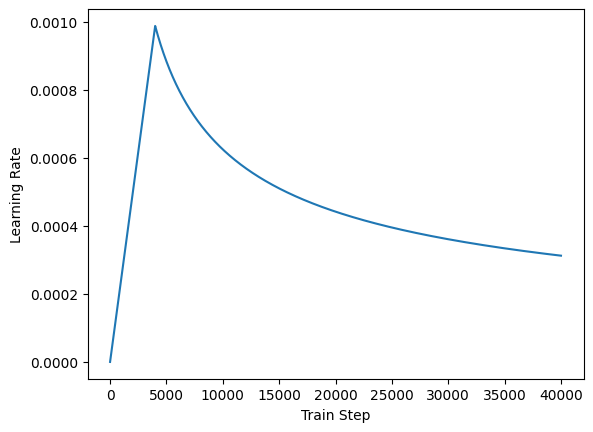

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [ ]:
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

### 훈련

In [ ]:
callbacks_list = [EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                patience=3, restore_best_weights=True),
                  TensorBoard(log_dir="/full_path_to_your_log_dir")
                  ]

history = model.fit(train_dataset, epochs=100, shuffle=True, validation_data=valid_dataset, callbacks=callbacks_list)

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 665s 447ms/step - loss: 7.5005 - masked_accuracy: 0.0817 - val_loss: 5.1151 - val_masked_accuracy: 0.1857
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 601s 427ms/step - loss: 4.9100 - masked_accuracy: 0.2007 - val_loss: 4.5806 - val_masked_accuracy: 0.2254
Epoch 3/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 601s 427ms/step - loss: 4.4920 - masked_accuracy: 0.2335 - val_loss: 4.4243 - val_masked_accuracy: 0.2423
Epoch 4/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 601s 427ms/step - loss: 4.2918 - masked_accuracy: 0.2537 - val_loss: 4.2797 - val_masked_accuracy: 0.2590
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 601s 427ms/step - loss: 4.1263 - masked_accuracy: 0.2709 - val_loss: 4.2118 - val_masked_accuracy: 0.2679
Epoch 6/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 601s 427ms/step - loss: 4.0194 - masked_accuracy: 0.2824 - val_loss: 4.1888 - val_masked_accuracy: 0.2720
Epoch 7/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 601s 427ms/step - loss: 3.9423 - masked_accuracy: 0.2909 - val_

In [ ]:
model.summary()

Model: "gpt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Decoder_PositionalEmbedding          │ ?                           │       3,916,800 │
│ (PositionalEmbedding)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 300, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer (DecoderLayer)         │ ?                           │       4,733,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_1 (DecoderLayer)       │ ?                           │       4,733,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_2 (DecoderLayer)       │ ?                           │       4,733,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_3 (DecoderLayer)       │ ?                           │       4,733,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 300, 15000)          │       3,855,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,116,682 (305.62 MB)

 Trainable params: 26,705,560 (101.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,411,122 (203.75 MB)

# 텍스트 생성

In [ ]:
text_gen = TextGenerator(tokenizer=sp, target_length=100, model=model)

In [ ]:
k = 3
text_gen(sentence='what the fuck is this?', k=k)

"what the fuck is this? it's so much more. it's hard not to believe that the movie was made for a budget. it's not a bad movie but it's just bad. the plot is so predictable and the acting is not that good either but it's not worth watching. it has the potential to be a good movie but it just falls flat. it's not worth seeing, but it's not worth watching. it's just a shame because the actors were so bad"